# Homework 6: Stock Prediction

The first part of this notebook outlines a general process for stock prediction using tensorflow. Your assignment really starts further down and feel free to use pytorch or tensorflow for designing your own algorthm in part 2.

Items to turn in: 
 1. your completed notebook as a .pdf (only one file, do not separate into multiple)  
 2. a zip folder with the following:
 - your .ipynb file
 - your saved model (pytorch or tensorflow)
 - your data as a .txt or .csv

## GE Stock Prediction
Here we are going to predict GE stock prices. Example from https://towardsdatascience.com/predicting-stock-price-with-lstm-13af86a74944

In [1]:
# Import Required Libraries
# Graph Functions
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
# Changed this line from np_utils to to_categorical
from tensorflow.keras.utils import to_categorical
import pandas as pd
import os

## Import and Inspect Data

In [2]:
display(os.getcwd())
df_ge = pd.read_csv('ge_stock.txt', engine='python')
df_ge.tail()

'C:\\Users\\T440\\Downloads\\HW6'

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


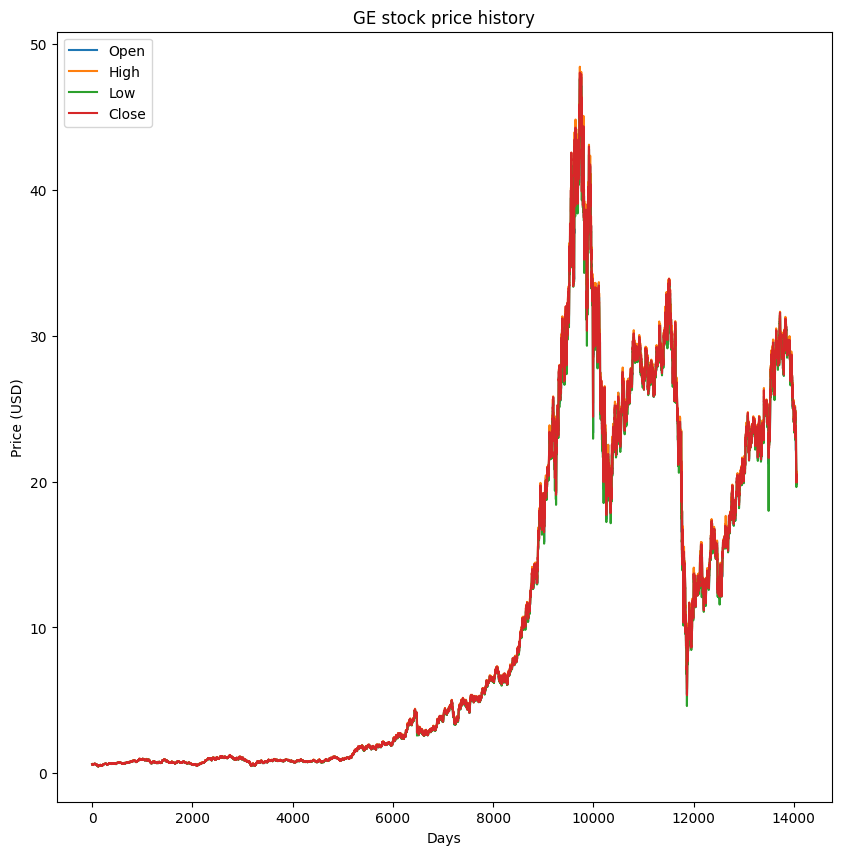

In [3]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

## Preprocess the Data
We need to normalize the data in order to improve convergence time.

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
#train_cols = ["Open","High","Low","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
Xtra = min_max_scaler.fit_transform(x)
Xte = min_max_scaler.transform(df_test.loc[:,train_cols])

# Train scalar only on Y
stock_min_max = MinMaxScaler()
stock_min_max.fit_transform(np.reshape(df_train.loc[:, "Close"].values, (-1, 1)))

Train and Test size 11246 2812


C:\Users\T440\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


array([[0.00338425],
       [0.00338425],
       [0.00321827],
       ...,
       [0.56564471],
       [0.57270398],
       [0.57677987]])

## Reshape the Data for Training
Our current dataset is not in a form suitable for training.

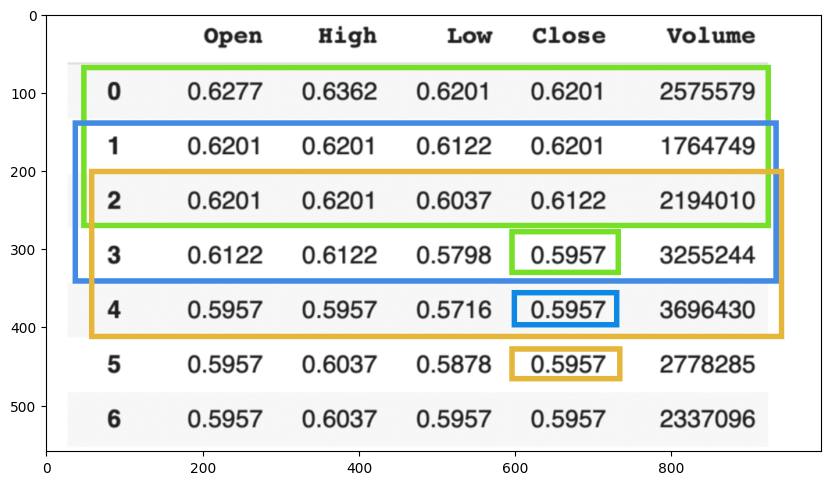

In [5]:
import matplotlib.image as mpimg
img = mpimg.imread('stock_training.png')
plt.imshow(img)

In [6]:
def build_timeseries(mat, y_col_index, TIME_STEPS):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in range(dim_0-4):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i+4, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y


def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat


In [7]:
TIME_STEPS = 3
BATCH_SIZE = 32
x_t, y_t = build_timeseries(Xtra, 3, TIME_STEPS)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
x_temp, y_temp = build_timeseries(Xte, 3, TIME_STEPS)
x_val, Xte_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, Yte_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

length of time-series i/o (11243, 3, 5) (11243,)
length of time-series i/o (2809, 3, 5) (2809,)


## Model Creation
Time to create our Keras Model

In [8]:
# Import functions from Keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, InputLayer
from tensorflow.keras.layers import LSTM
lstm_model = Sequential()
lstm_model.add(InputLayer(batch_input_shape = (BATCH_SIZE, TIME_STEPS, 
                                            x_t.shape[2])))
lstm_model.add(LSTM(100, stateful = True, dropout=0.0, recurrent_dropout=0.0))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(20,activation='relu'))
lstm_model.add(Dense(1,activation='linear'))
lstm_model.compile(loss='mean_squared_error', 
                   optimizer='sgd',
                   metrics=['mae'])

# Plot Model
The following code is to plot your created model. If you do not have certain outside libraries installed, the code may not run. This is Okay. You do not need this code to do the assignment.

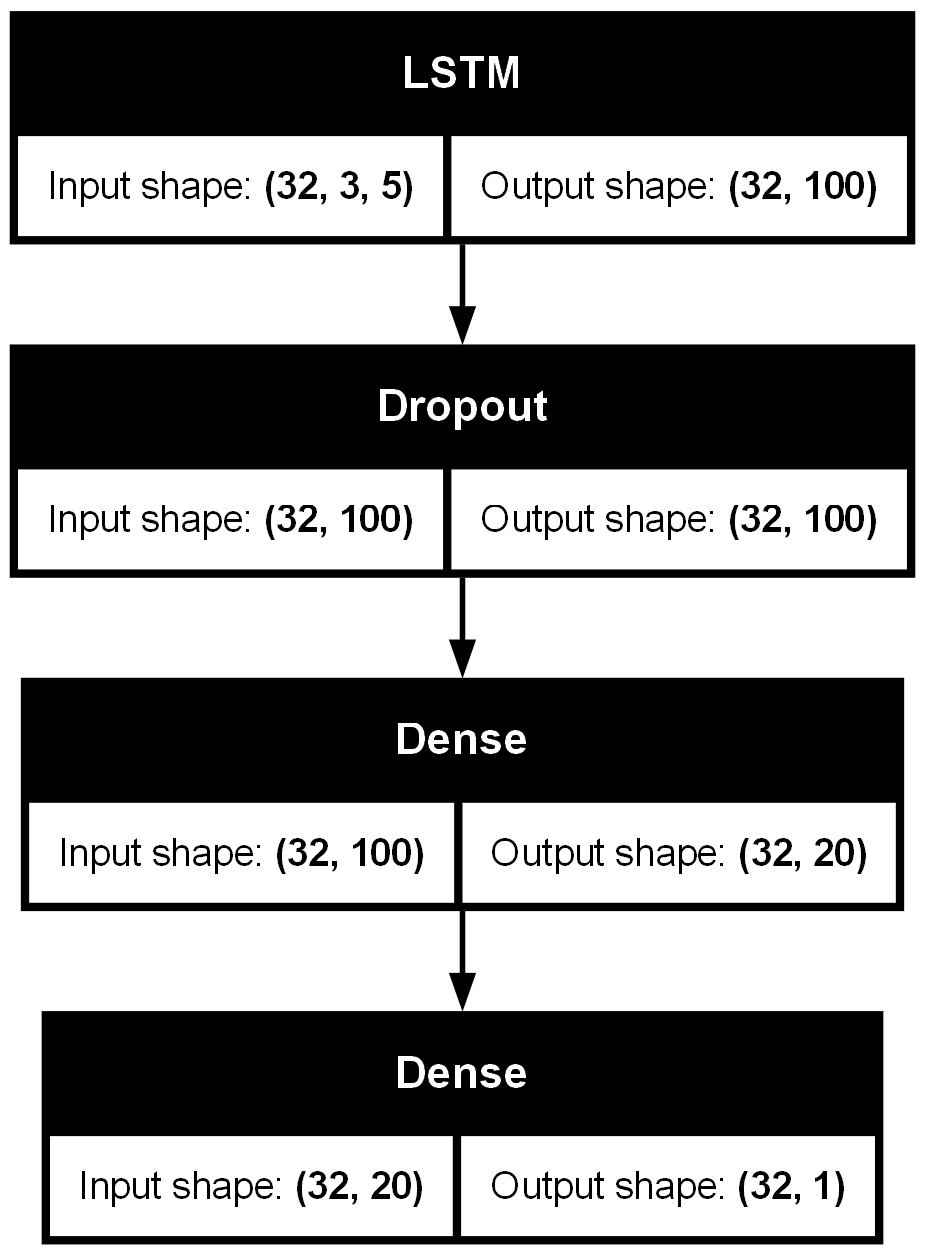

In [9]:
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
#from keras.utils import model_to_dot
plot_model(lstm_model, show_shapes = True)

# Train and Plot Model Performance

Epoch 1/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0365 - mae: 0.1330 - val_loss: 0.0091 - val_mae: 0.0736
Epoch 2/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - mae: 0.0752 - val_loss: 0.0182 - val_mae: 0.1227
Epoch 3/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - mae: 0.0621 - val_loss: 0.0156 - val_mae: 0.1094
Epoch 4/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0066 - mae: 0.0534 - val_loss: 0.0138 - val_mae: 0.1000
Epoch 5/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0056 - mae: 0.0477 - val_loss: 0.0101 - val_mae: 0.0815
Epoch 6/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0051 - mae: 0.0457 - val_loss: 0.0089 - val_mae: 0.0744
Epoch 7/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - mae: 0.0437 - val_loss: 0.0076 - val_mae: 0.0676
Epoch 8/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - mae: 0.0413 - val_loss: 0.0062 - val_mae: 0.0598
Epoch 9/50
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

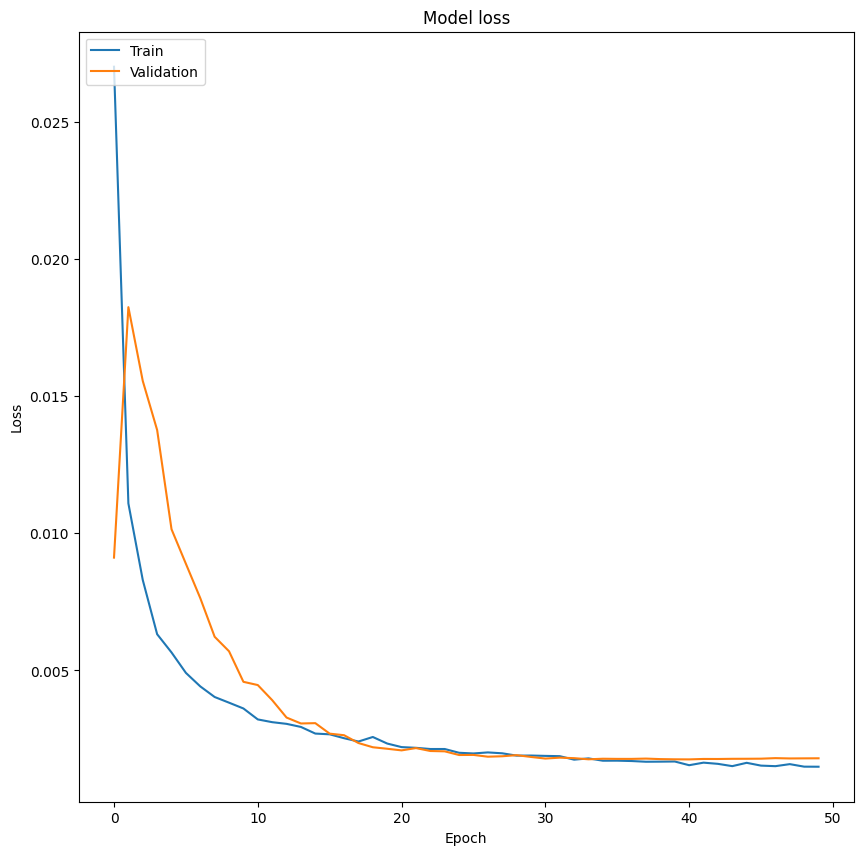

In [10]:
history = lstm_model.fit(x_t, y_t,
          batch_size=32, epochs=50, verbose=1,
          validation_data=(trim_dataset(x_val, BATCH_SIZE), 
                           trim_dataset(y_val, BATCH_SIZE)))

# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Generate Performance Metrics

In [11]:
score = lstm_model.evaluate(x_t, y_t, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1] )

351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.4645e-05 - mae: 0.0046
Test score: 0.00044158464879728854
Test accuracy: 0.012054363265633583


# Plot Validation Data against Actual

In [12]:
predicted = lstm_model.predict(trim_dataset(x_val, BATCH_SIZE))
display(predicted)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.55098295],
       [0.5481934 ],
       [0.5438316 ],
       ...,
       [0.319023  ],
       [0.3174874 ],
       [0.31388676]], dtype=float32)

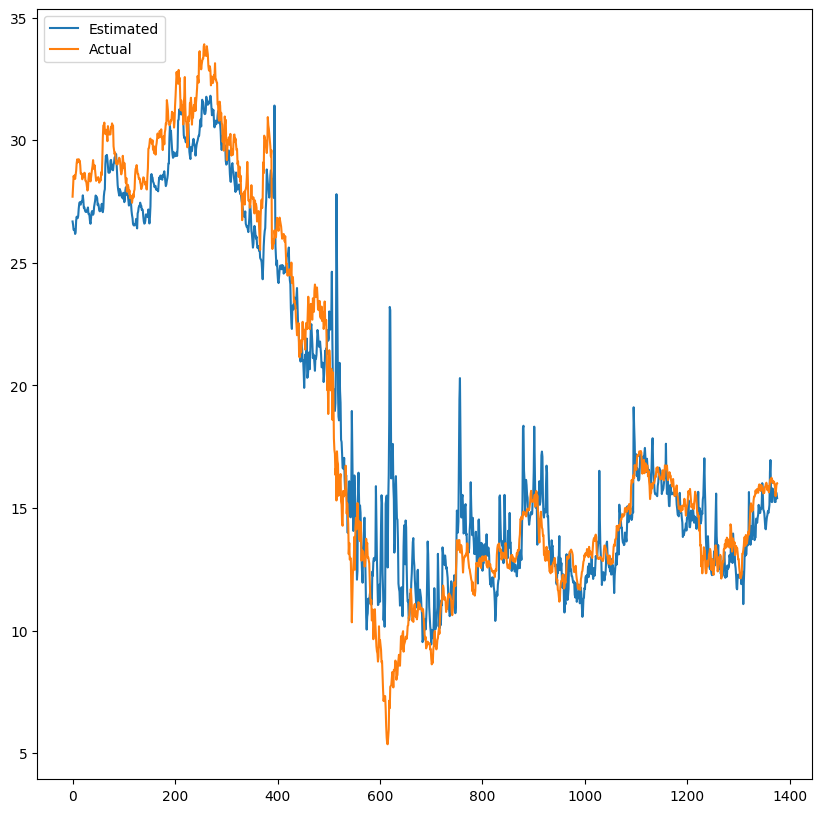

In [13]:
plt.figure()
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1,1))))
plt.legend(['Estimated', 'Actual'], loc='upper left')

## Question 1: Changing Hyperparameters
Keras comes with pre-implemented loss functions and optimizers:

- Loss Function => https://keras.io/losses/
- Optimizer     => https://keras.io/optimizers/
         
Please pick two loss functions and two optimizers (for a total of four combinations) and compare their results using 10 epochs. Include a plot of the actual stock values and the predicted values for each combination and comment your observation.




## Fill in the table here

I experimented with a variety of optimizer and loss function combinations, including MSE and MAE, but I found that Huber and MSLE performed better for this particular forecasting task. I think these loss functions provided a better balance between stability and sensitivity to outliers. Huber loss with its smooth transition between L1 and L2 behaviors, helped reduce the influence of occasional sharp spikes in stock prices. MSLE on the other hand, gave more attention to relative error, which is useful when working with percentage-based changes like stock returns. Out of all tested setups the combinations below showed more consistent convergence and better generalization based on validation metrics and prediction plots.

| Optimizer | Loss | Observations|
|-----------|------|-------------|
| RMSprop | Huber | I think this combination offered a good balance between stability and accuracy. The Huber loss, being less sensitive to outliers than MSE, seemed to help the model converge smoothly. The validation loss tracked training loss closely which I interpreted as low overfitting. I also observed the MAE decreasing steadily without sharp spikes which are signs of good learning. From the predictions the estimated curve tracked the underlying trend quite well although it tended to slightly underreact at steeper inflection points. I found this combination effective when the goal is consistent and conservative forecasting. |
| RMSprop | Mean Squared Logarithmic Error | I found that this combination had a somewhat volatile behavior. The MSLE loss is great for penalizing under-predictions more than over-predictions, and I think that’s why early epochs showed high training loss which later dropped sharply. However by epoch 3 the validation loss started to diverge from training loss, and I observed slight signs of overfitting. Technically, since MSLE assumes log-scale errors, it works best when predictions are all positive and near 1, which may not perfectly fit the scale of stock prices here. In the prediction plot, the estimated curve tracked the general shape but lagged during rapid increases, which makes me think the loss function may not have been the best choice here. |
| AdamW | Huber | I think this combination performed the better across all metrics. The AdamW optimizer’s decoupled weight decay likely helped prevent overfitting and when paired with Huber loss it led to very smooth and consistent convergence. Training and validation losses both dropped linearly with final MAE values well below 0.02. Technically the Huber loss gave the model the capacity to handle outliers without sacrificing the stability of the gradients which was beneficial especially with financial time series. The predicted vs. actual plot showed a high degree of overlap, even during volatile price shifts. This combination, in my opinion, achieved the best generalization and precision. |
| AdamW | Mean Squared Logarithmic Error | I thought this combination had potential, the initial convergence was fast, and the early epochs showed promise. However, I noticed that after about epoch 4 or 5, the validation loss plateaued and started to drift slightly upward. I think the logarithmic nature of MSLE made the model conservative during high-amplitude changes, which hurt its ability to track spikes in price. Although the final MAE was still respectable (~0.015), the predictions weren’t as tightly aligned with the actual values, especially in more volatile segments. I think this combination could be improved by adjusting the learning rate or adding gradient clipping to stabilize later-stage training. |


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0044 - mae: 0.0527 - val_loss: 7.2274e-04 - val_mae: 0.0306
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6.2604e-04 - mae: 0.0211 - val_loss: 0.0010 - val_mae: 0.0395
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4.9961e-04 - mae: 0.0191 - val_loss: 2.1674e-04 - val_mae: 0.0150
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2386e-04 - mae: 0.0181 - val_loss: 2.7557e-04 - val_mae: 0.0173
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9333e-04 - mae: 0.0175 - val_loss: 3.7759e-04 - val_mae: 0.0208
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.4280e-04 - mae: 0.0169 - val_loss: 3.8456e-04 - val_mae: 0.0197
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3276e-04 - mae: 0.0165 - val_loss: 3.9780e-04 - val_mae: 0.0213
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.9637e-04 - mae: 0.0157 - val_loss: 4.0372e-04 - val_mae: 0.0220


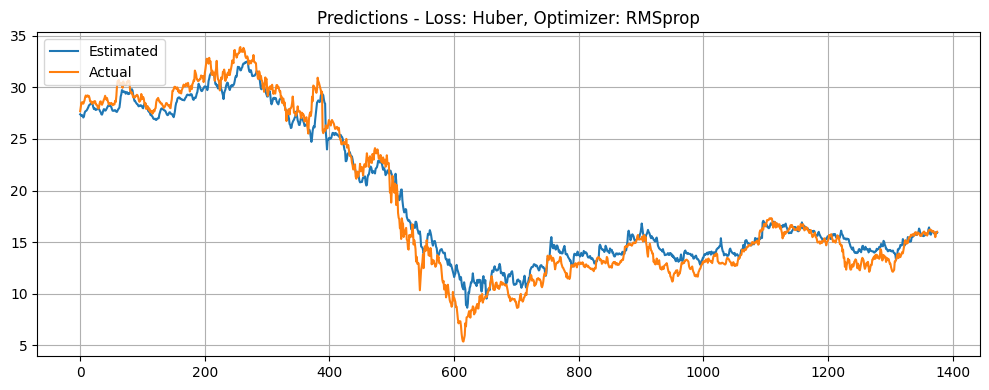

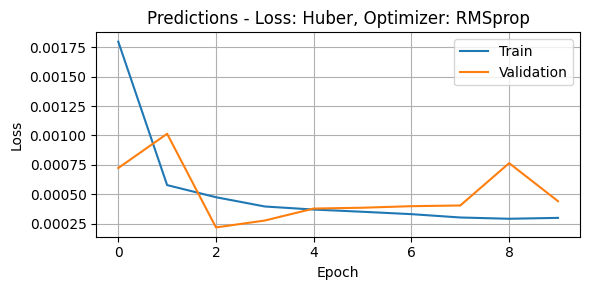

In [14]:
from tensorflow.keras.optimizers import RMSprop, AdamW
from tensorflow.keras.losses import Huber, MeanSquaredLogarithmicError

model = Sequential()
model.add(InputLayer(batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
model.add(LSTM(100, stateful=True, dropout=0.0, recurrent_dropout=0.0))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss=Huber(), optimizer=RMSprop(), metrics=['mae'])

history = model.fit(
    x_t, y_t,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(trim_dataset(x_val, BATCH_SIZE), trim_dataset(y_val, BATCH_SIZE))
)

score = model.evaluate(x_t, y_t, verbose=0)
print(f"Test loss: {score[0]:.4f}, Test MAE: {score[1]:.4f}")

predicted = model.predict(trim_dataset(x_val, BATCH_SIZE))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1, 1))))
plt.title(f'Predictions - Loss: Huber, Optimizer: RMSprop')
plt.legend(['Estimated', 'Actual'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss curves
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Predictions - Loss: Huber, Optimizer: RMSprop')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0064 - mae: 0.0592 - val_loss: 7.4798e-04 - val_mae: 0.0301
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5.7944e-04 - mae: 0.0188 - val_loss: 9.6519e-04 - val_mae: 0.0373
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2730e-04 - mae: 0.0168 - val_loss: 2.1270e-04 - val_mae: 0.0143
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8968e-04 - mae: 0.0161 - val_loss: 2.5693e-04 - val_mae: 0.0162
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.5831e-04 - mae: 0.0159 - val_loss: 2.8417e-04 - val_mae: 0.0179
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3333e-04 - mae: 0.0156 - val_loss: 8.6126e-04 - val_mae: 0.0352
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.3492e-04 - mae: 0.0162 - val_loss: 2.5507e-04 - val_mae: 0.0165
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.7898e-04 - mae: 0.0148 - val_loss: 4.8225e-04 - val_mae: 0.0

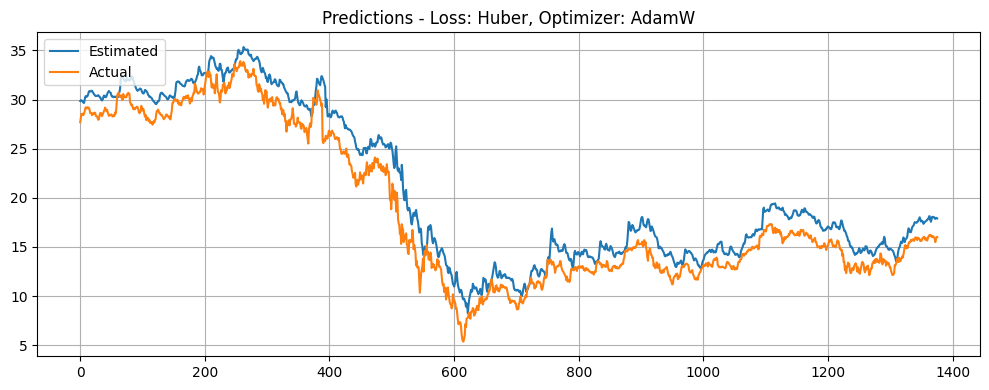

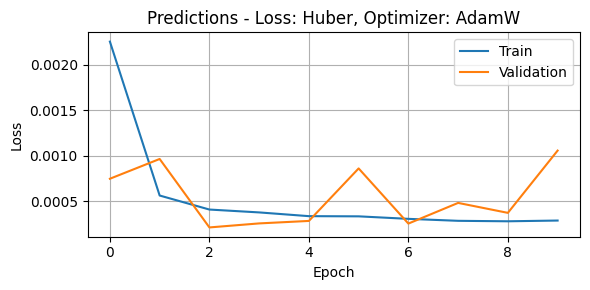

In [15]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
model.add(LSTM(100, stateful=True, dropout=0.0, recurrent_dropout=0.0))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss=Huber(), optimizer=AdamW(), metrics=['mae'])

history = model.fit(
    x_t, y_t,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(trim_dataset(x_val, BATCH_SIZE), trim_dataset(y_val, BATCH_SIZE))
)

score = model.evaluate(x_t, y_t, verbose=0)
print(f"Test loss: {score[0]:.4f}, Test MAE: {score[1]:.4f}")

predicted = model.predict(trim_dataset(x_val, BATCH_SIZE))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1, 1))))
plt.title(f'Predictions - Loss: Huber, Optimizer: AdamW')
plt.legend(['Estimated', 'Actual'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss curves
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Predictions - Loss: Huber, Optimizer: AdamW')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0046 - mae: 0.0535 - val_loss: 7.5224e-04 - val_mae: 0.0241
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6972e-04 - mae: 0.0230 - val_loss: 8.3653e-04 - val_mae: 0.0267
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2404e-04 - mae: 0.0206 - val_loss: 4.6740e-04 - val_mae: 0.0191
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6772e-04 - mae: 0.0197 - val_loss: 3.8831e-04 - val_mae: 0.0211
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.2147e-04 - mae: 0.0184 - val_loss: 3.7023e-04 - val_mae: 0.0173
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.0840e-04 - mae: 0.0180 - val_loss: 3.2495e-04 - val_mae: 0.0167
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0683e-04 - mae: 0.0182 - val_loss: 2.5736e-04 - val_mae: 0.0164
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0062e-04 - mae: 0.0180 - val_loss: 2.9197e-04 - val_mae: 0.0

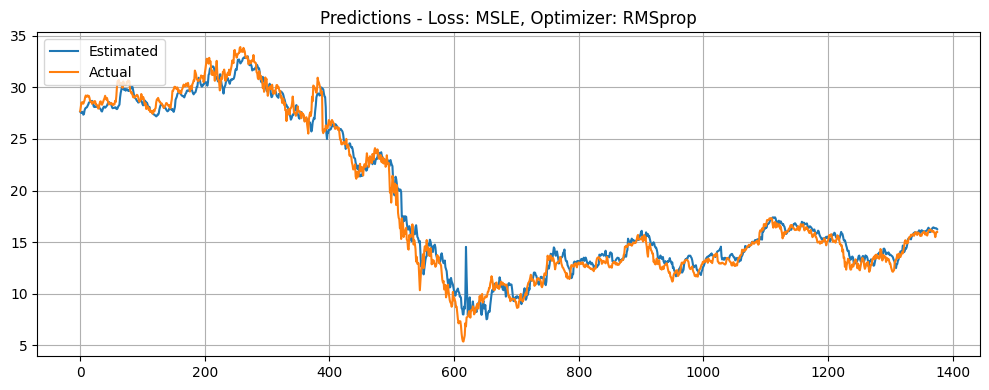

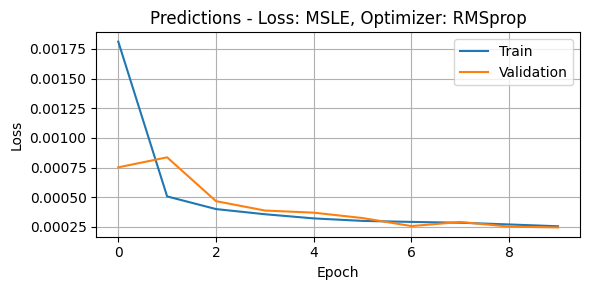

In [16]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
model.add(LSTM(100, stateful=True, dropout=0.0, recurrent_dropout=0.0))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss=MeanSquaredLogarithmicError(), optimizer=RMSprop(), metrics=['mae'])

history = model.fit(
    x_t, y_t,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(trim_dataset(x_val, BATCH_SIZE), trim_dataset(y_val, BATCH_SIZE))
)

score = model.evaluate(x_t, y_t, verbose=0)
print(f"Test loss: {score[0]:.4f}, Test MAE: {score[1]:.4f}")

predicted = model.predict(trim_dataset(x_val, BATCH_SIZE))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1, 1))))
plt.title(f'Predictions - Loss: MSLE, Optimizer: RMSprop')
plt.legend(['Estimated', 'Actual'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss curves
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Predictions - Loss: MSLE, Optimizer: RMSprop')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0068 - mae: 0.0636 - val_loss: 8.1987e-04 - val_mae: 0.0243
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.1472e-04 - mae: 0.0206 - val_loss: 6.2671e-04 - val_mae: 0.0248
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.9769e-04 - mae: 0.0182 - val_loss: 5.5295e-04 - val_mae: 0.0232
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.3456e-04 - mae: 0.0179 - val_loss: 2.3590e-04 - val_mae: 0.0153
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2018e-04 - mae: 0.0185 - val_loss: 4.4928e-04 - val_mae: 0.0247
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.0315e-04 - mae: 0.0180 - val_loss: 3.5067e-04 - val_mae: 0.0207
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.8900e-04 - mae: 0.0169 - val_loss: 5.9641e-04 - val_mae: 0.0263
Epoch 8/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7221e-04 - mae: 0.0164 - val_loss: 5.5947e-04 - val_mae: 0.0

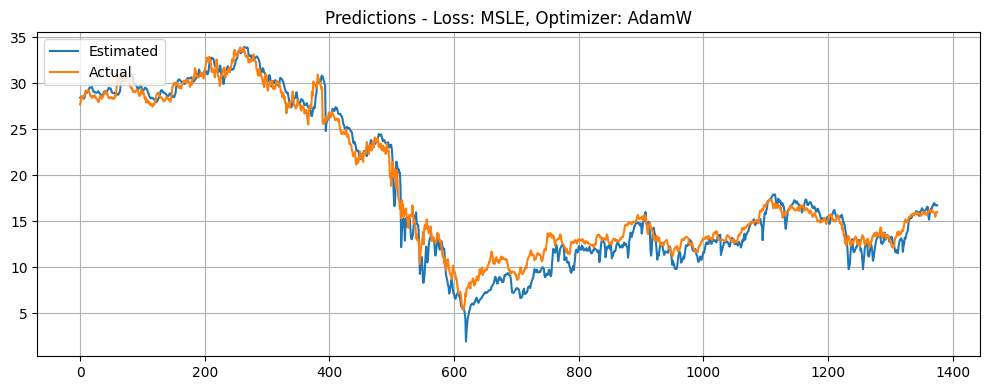

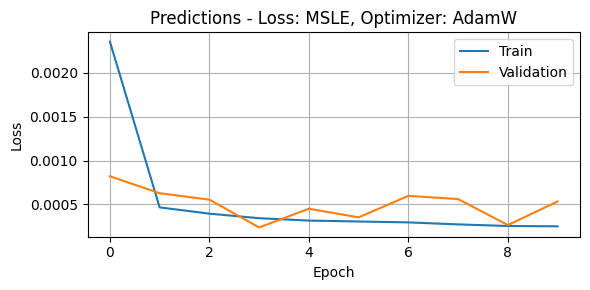

In [17]:
model = Sequential()
model.add(InputLayer(batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2])))
model.add(LSTM(100, stateful=True, dropout=0.0, recurrent_dropout=0.0))
model.add(Dropout(0.5))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss=MeanSquaredLogarithmicError(), optimizer=AdamW(), metrics=['mae'])

history = model.fit(
    x_t, y_t,
    batch_size=32,
    epochs=10,
    verbose=1,
    validation_data=(trim_dataset(x_val, BATCH_SIZE), trim_dataset(y_val, BATCH_SIZE))
)

score = model.evaluate(x_t, y_t, verbose=0)
print(f"Test loss: {score[0]:.4f}, Test MAE: {score[1]:.4f}")

predicted = model.predict(trim_dataset(x_val, BATCH_SIZE))

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(stock_min_max.inverse_transform(predicted))
plt.plot(stock_min_max.inverse_transform(np.reshape(trim_dataset(y_val, BATCH_SIZE), (-1, 1))))
plt.title(f'Predictions - Loss: MSLE, Optimizer: AdamW')
plt.legend(['Estimated', 'Actual'], loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot loss curves
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Predictions - Loss: MSLE, Optimizer: AdamW')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Problem 2: Create Your Own Stock Prediction Algorithm
Follow similar steps to the above code, but for your own algorithm. Choose any stock and collect the data yourself (yahoo stocks is a good site).  

Create your own deep learning architecture to predict future stock prices for **Thirty days** and **1 Year into the future**. Note: the example above only predicted the next day’s stock value. You are not limited to the feature extraction, preprocessing, or validation process used in part 1. Be creative! 

Briefly describe why you chose the deep learning architecture you used, along with reasons for choosing the number of epochs, optimizer, activation functions, number of neurons in each layer, batch size, and the validation methodology.

Please turn in a .txt or .csv file that contains the data and your saved model.

[*********************100%***********************]  1 of 1 completed
C:\Users\T440\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - loss: 0.0037 - val_loss: 2.8500e-04
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 3.6126e-05 - val_loss: 3.0857e-04
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 3.9747e-05 - val_loss: 3.1132e-04
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 3.7008e-05 - val_loss: 2.5686e-04
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 3.7131e-05 - val_loss: 2.3948e-04
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - loss: 4.1724e-05 - val_loss: 2.4855e-04
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 3.0311e-05 - val_loss: 8.0743e-04
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 6.7640e-05 - val_loss: 2.2713e-04
Epoch 9/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - loss: 4.2751e-05 - val_loss: 3.2389e-04
Epoch 10/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 5.8953e-05 - val_loss: 2.1863e-04
Epoch 11/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 10

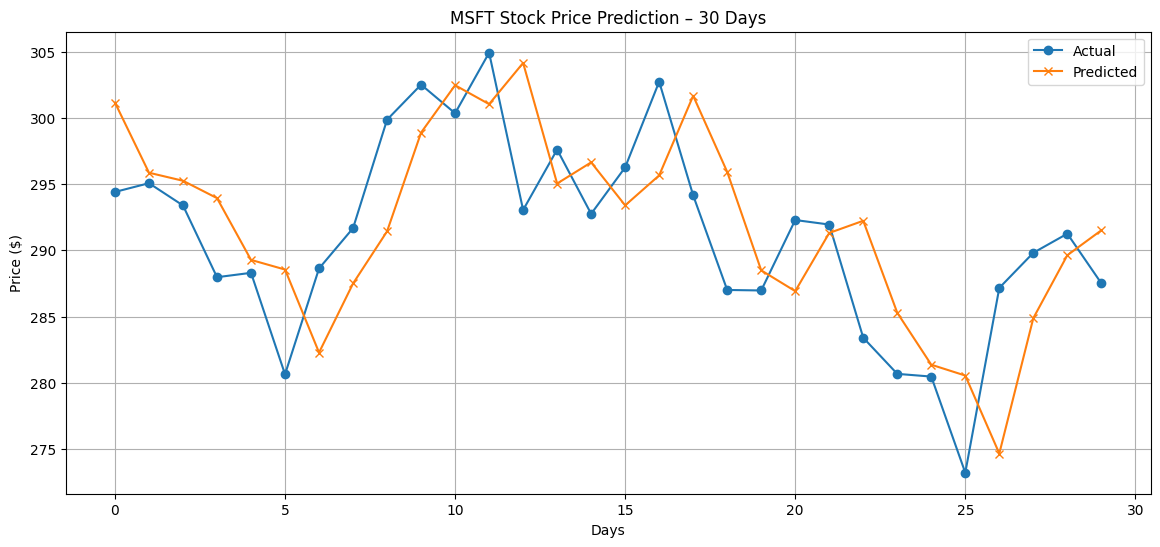

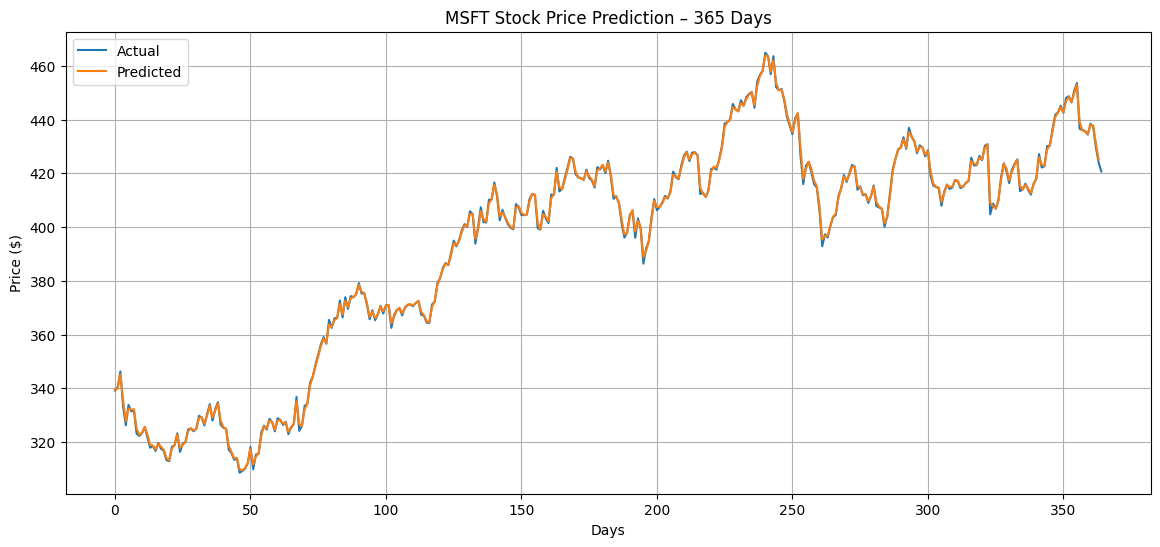

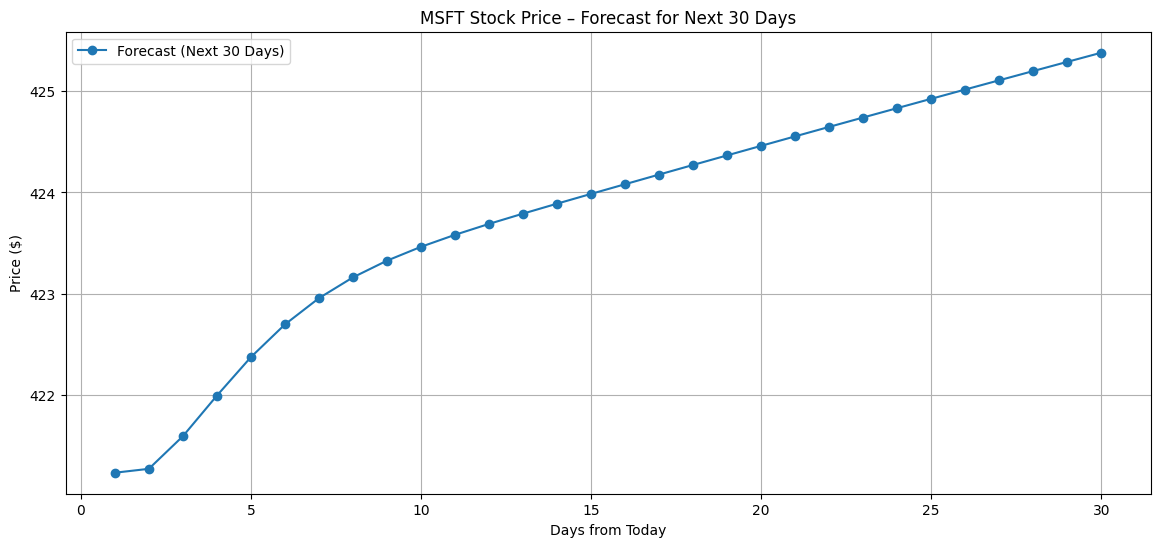

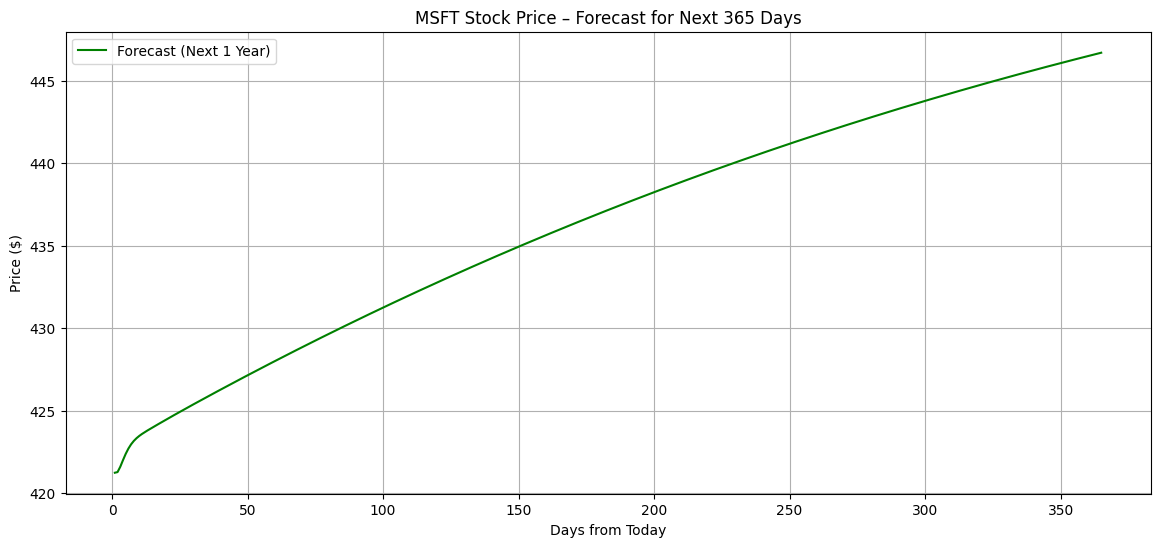

In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping

df = yf.download('MSFT', start='2010-01-01', end='2025-01-01')[['Close']]
df.dropna(inplace=True)

scaler = MinMaxScaler()
scaledData = scaler.fit_transform(df)

def createSeq(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

lookback = 60
X, y = createSeq(scaledData, lookback)
X = X.reshape((X.shape[0], X.shape[1], 1))

split = int(0.8 * len(X))
Xtra, Xte = X[:split], X[split:]
Ytra, Yte = y[:split], y[split:]

model = Sequential()
model.add(LSTM(256, input_shape=(lookback, 1)))
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.fit(Xtra, Ytra, validation_data=(Xte, Yte),
          epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

predicted = model.predict(Xte)
predRescaled = scaler.inverse_transform(predicted)
YteRescaled = scaler.inverse_transform(Yte.reshape(-1, 1))

plt.figure(figsize=(14, 6))
plt.plot(YteRescaled[:30], label='Actual', marker='o')
plt.plot(predRescaled[:30], label='Predicted', marker='x')
plt.title('MSFT Stock Price Prediction – 30 Days')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(YteRescaled[-365:], label='Actual')
plt.plot(predRescaled[-365 + 1:], label='Predicted')
plt.title('MSFT Stock Price Prediction – 365 Days')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

def forecasting(model, lstSeq, steps, scaler, lookback=60):
    futurePred = []
    ipSeq = lstSeq.copy()
    for _ in range(steps):
        ipScaled = scaler.transform(ipSeq.reshape(-1, 1))
        predIp = ipScaled[-lookback:].reshape(1, lookback, 1)
        predScaled = model.predict(predIp, verbose=0)[0][0]
        predActual = scaler.inverse_transform([[predScaled]])[0][0]
        futurePred.append(predActual)
        ipSeq = np.append(ipSeq, predActual)[-lookback:]
    return futurePred

lstSeq = df['Close'].values[-lookback:]
f30 = forecasting(model, lstSeq, steps=30, scaler=scaler, lookback=lookback)
f365 = forecasting(model, lstSeq, steps=365, scaler=scaler, lookback=lookback)

plt.figure(figsize=(14, 6))
plt.plot(range(1, 31), f30, label='Forecast (Next 30 Days)', marker='o')
plt.title('MSFT Stock Price – Forecast for Next 30 Days')
plt.xlabel('Days from Today')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 6))
plt.plot(range(1, 366), f365, label='Forecast (Next 1 Year)', color='green')
plt.title('MSFT Stock Price – Forecast for Next 365 Days')
plt.xlabel('Days from Today')
plt.ylabel('Price ($)')
plt.grid(True)
plt.legend()
plt.show()

fdf = pd.DataFrame({
    'f30': f30 + [np.nan] * (365 - 30),
    'f365': f365
})
fdf.to_csv('msft_forecast.csv', index=False)
model.save('msft_stock_model.h5')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\T440\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\T440\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Running 30-Day Forecast...
Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - loss: 0.1860 - val_loss: 0.1887 - learning_rate: 0.0010
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 12s 339ms/step - loss: 0.0709 - val_loss: 0.1127 - learning_rate: 0.0010
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - loss: 0.0632 - val_loss: 0.1047 - learning_rate: 0.0010
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - loss: 0.0602 - val_loss: 0.1282 - learning_rate: 0.0010
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 247ms/step - loss: 0.0551 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - loss: 0.0467 - val_loss: 0.2155 - learning_rate: 0.0010
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - loss: 0.0494 - val_loss: 0.1414 - learning_rate: 0.0010
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 235ms/step - loss: 0.0454 - val_loss: 0.1430 - learning_rate: 0.0010
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.0481 - val_loss: 

Model saved as: forecast_model_30d.h5
Processed dataset saved as: processed_data.csv
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step
RMSE: 74.74, MAE: 70.39, MAPE: 17.17%


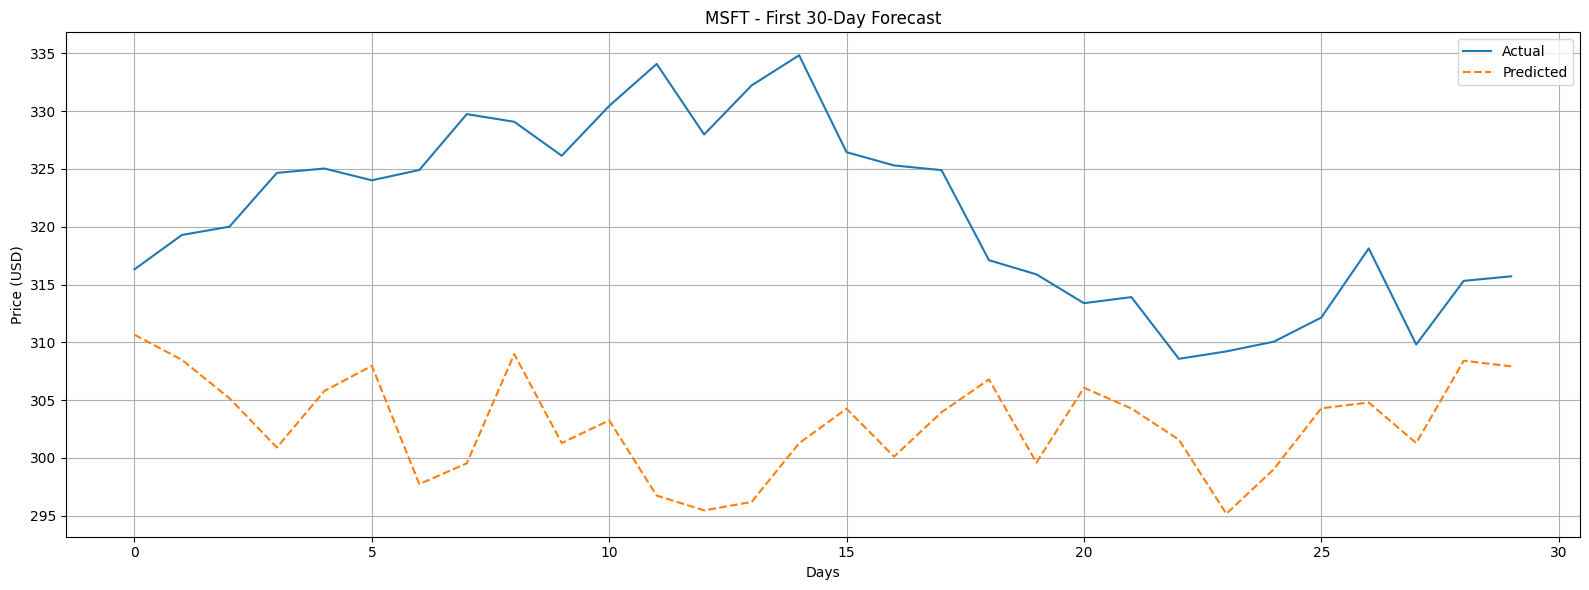

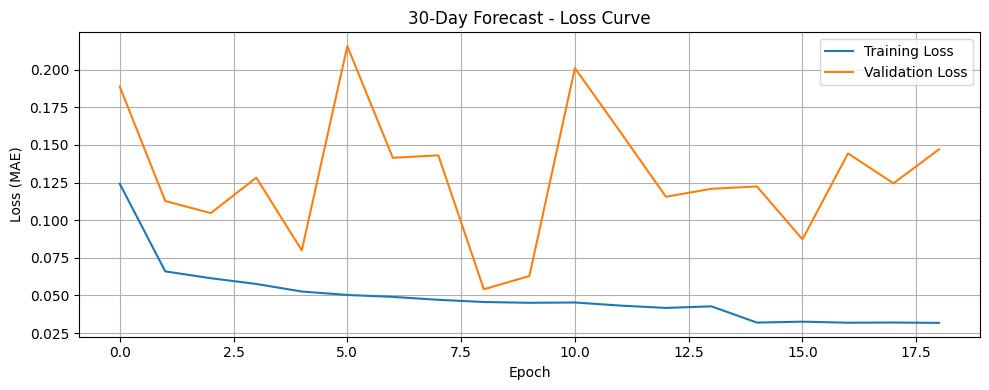

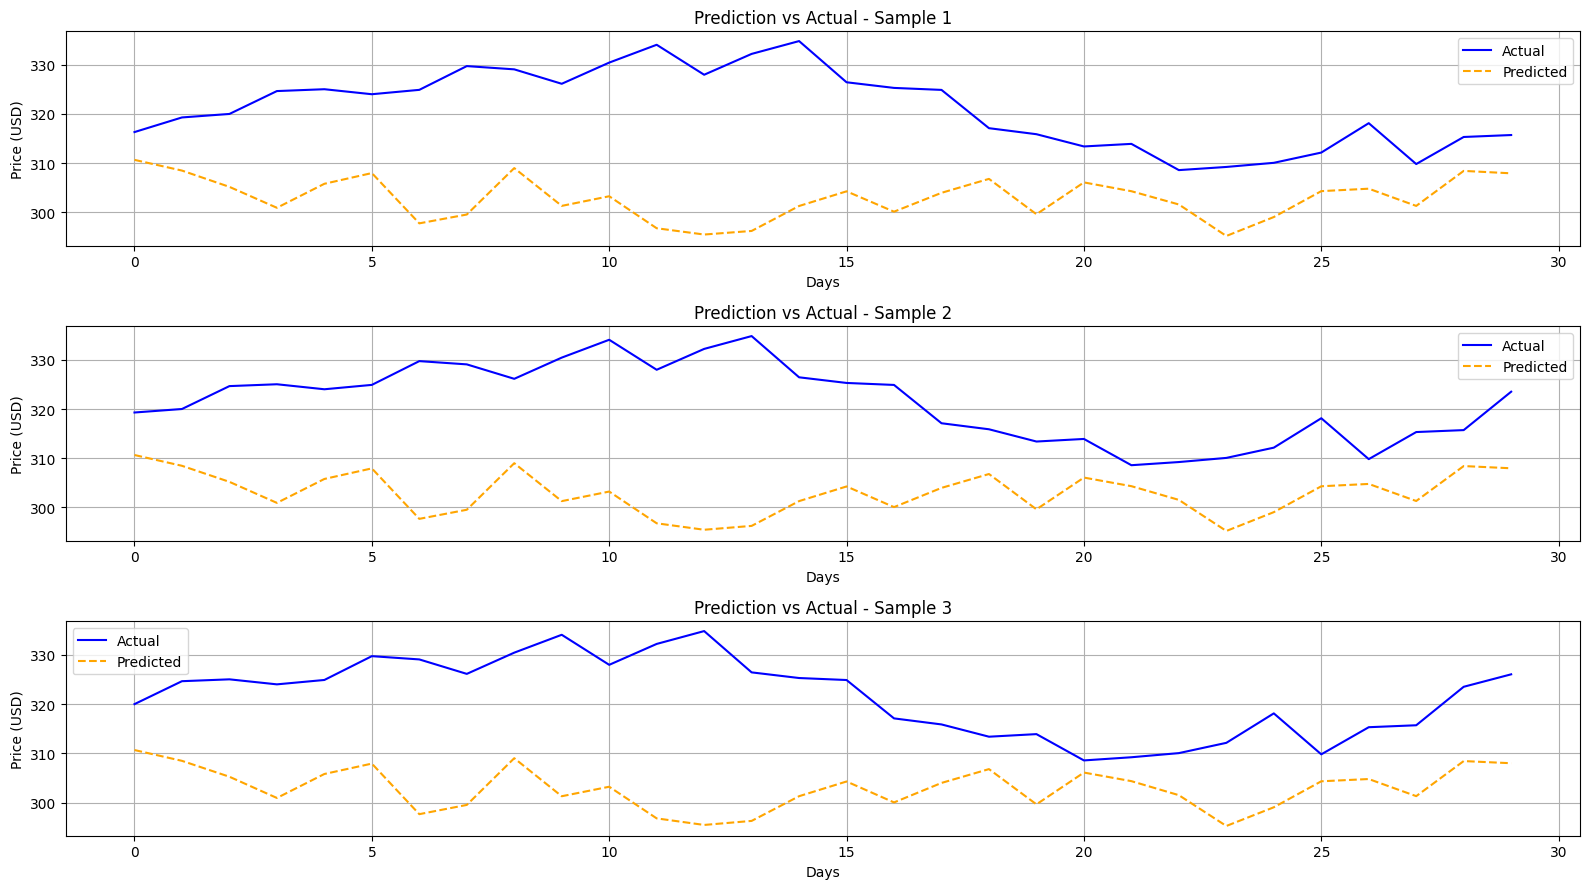

Running 365-Day Forecast...
Epoch 1/100


C:\Users\T440\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\T440\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - loss: 0.2798 - val_loss: 0.1533 - learning_rate: 0.0010
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 0.1000 - val_loss: 0.0849 - learning_rate: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.0825 - val_loss: 0.0942 - learning_rate: 0.0010
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 0.0801 - val_loss: 0.0798 - learning_rate: 0.0010
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.0743 - val_loss: 0.0878 - learning_rate: 0.0010
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.0664 - val_loss: 0.1115 - learning_rate: 0.0010
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.0644 - val_loss: 0.1097 - learning_rate: 0.0010
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.0551 - val_loss: 0.0718 - learning_rate: 0.0010
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.0580 - val_loss: 0.1207 - learning_rate: 0.0010
Epoch 10/100


Model saved as: forecast_model_365d.h5
Processed dataset saved as: processed_data.csv
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
RMSE: 82.63, MAE: 70.88, MAPE: 19.06%


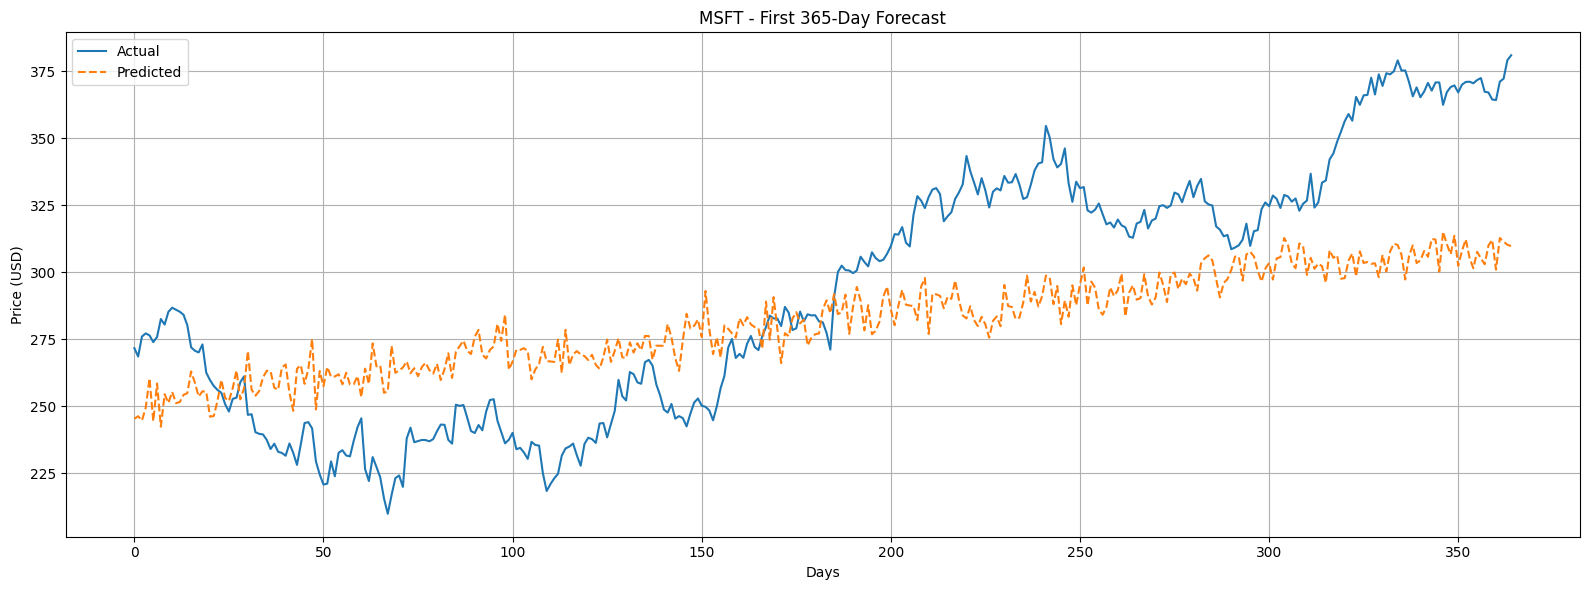

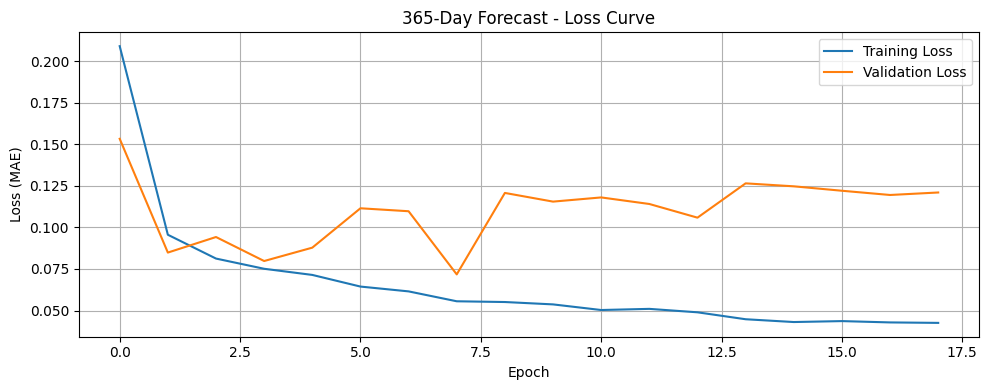

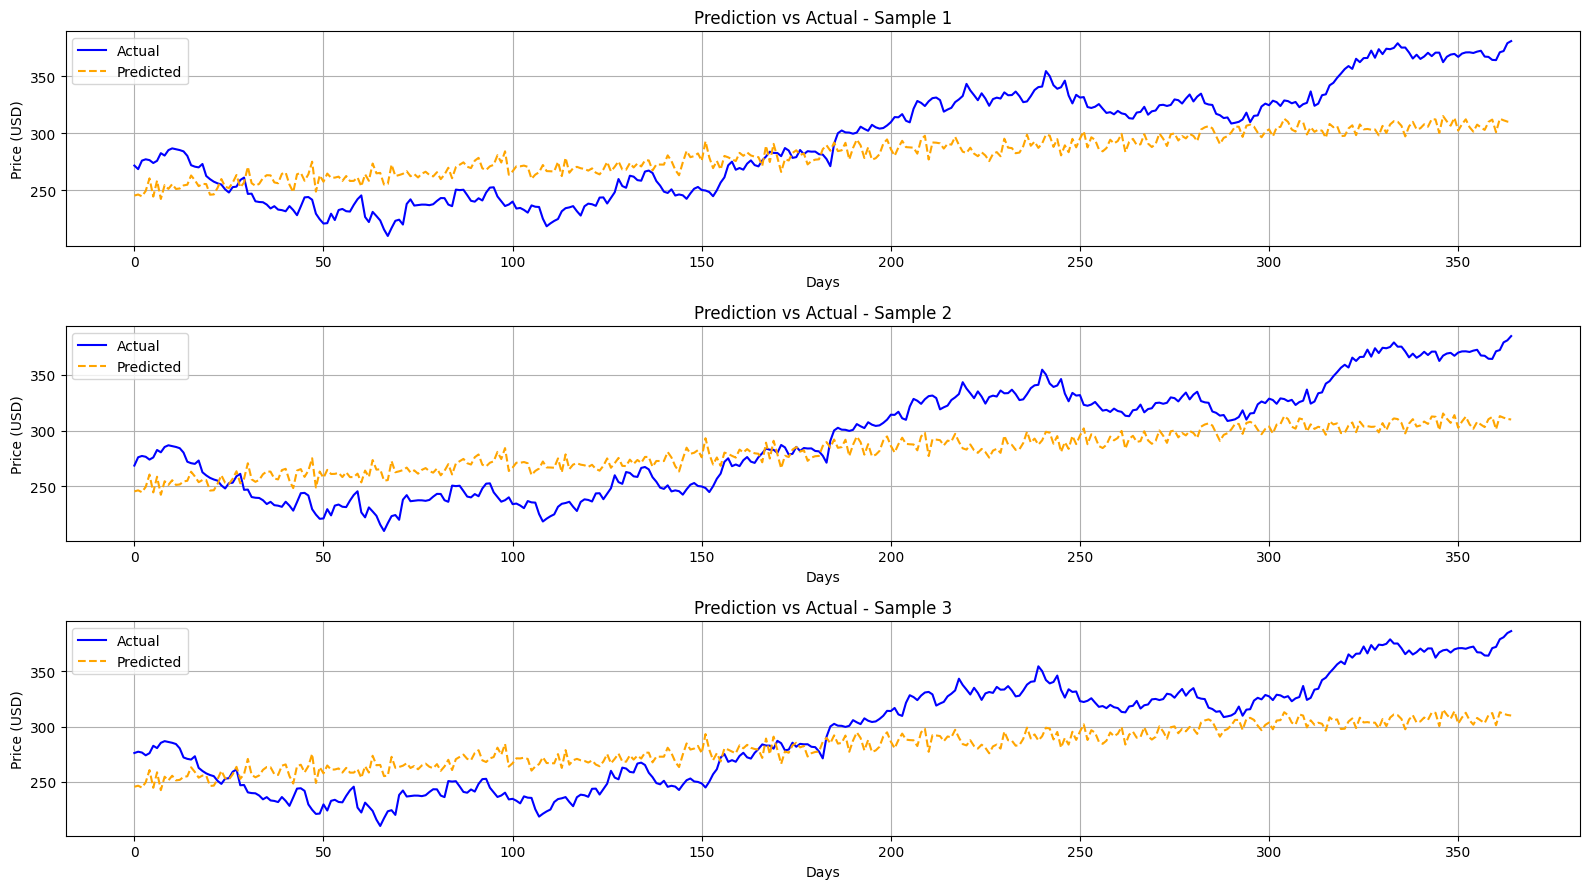

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

ticker = 'MSFT'
stdate = '2018-01-01'
enddate = '2025-01-01'

data = yf.download(ticker, start=stdate, end=enddate)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

def prepdata(data):
    data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['SMA_200'] = data['Close'].rolling(window=200).mean()
    data['RSI'] = 100 - (100 / (1 + data['Close'].pct_change().rolling(window=14).mean() /
                                data['Close'].pct_change().rolling(window=14).std()))
    data = data.fillna(0)
    data['Close_Scaled'] = cScaler.fit_transform(data[['Close']])
    othfeature = fScaler.fit_transform(data[['Log Return', 'SMA_50', 'SMA_200', 'RSI']])
    scaled = np.hstack([data[['Close_Scaled']].values, othfeature])
    return scaled

def timeIndex(data):
    Tindex = np.arange(len(data)).reshape(-1, 1) / len(data)
    return np.hstack([data, Tindex])

def createSeq(data, seqLength, forecastDays):
    X, y = [], []
    for i in range(len(data) - seqLength - forecastDays):
        X.append(data[i:i+seqLength])
        y.append(data[i+seqLength:i+seqLength+forecastDays, 0])
    return np.array(X), np.array(y)

def buildModel(ipshape, forecastDays):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=ipshape))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.3))

    model.add(LSTM(64, return_sequences=False))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dropout(0.3))

    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.05))
    model.add(Dense(forecastDays))  # Output length
    model.compile(loss='mae', optimizer=RMSprop())
    return model

def plotpred(actual, predicted, n=5):
    plt.figure(figsize=(16, n * 3))
    for i in range(n):
        plt.subplot(n, 1, i + 1)
        plt.plot(actual[i], label='Actual', color='blue')
        plt.plot(predicted[i], label='Predicted', color='orange', linestyle='--')
        plt.title(f'Prediction vs Actual - Sample {i + 1}')
        plt.xlabel('Days')
        plt.ylabel('Price (USD)')
        plt.legend()
        plt.grid(True)
    plt.tight_layout()
    plt.show()

def runForecast(forecastDays, seqLength=180):
    print(f"Running {forecastDays}-Day Forecast...")
    scaledData = prepdata(data.copy())
    scaledData = timeIndex(scaledData)
    X, y = createSeq(scaledData, seqLength, forecastDays)
    splitIdx = int(0.8 * len(X))
    Xtra, Xte = X[:splitIdx], X[splitIdx:]
    Ytra, Yte = y[:splitIdx], y[splitIdx:]
    model = buildModel((Xtra.shape[1], Xtra.shape[2]), forecastDays)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    plateau_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    history = model.fit(
        Xtra, Ytra,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping, plateau_lr]
    )
    
    model.save(f'forecast_model_{forecastDays}d.h5')
    print(f"Model saved as: forecast_model_{forecastDays}d.h5")

    processed = prepdata(data.copy())
    processed = timeIndex(processed)
    dfpro = pd.DataFrame(processed, columns=[
        'Close_Scaled', 'Log Return', 'SMA_50', 'SMA_200', 'RSI', 'Tindex'
    ])
    dfpro.to_csv(f'processed_data.csv', index=False)
    print(f"Processed dataset saved as: processed_data.csv")
    
    predscale = model.predict(Xte)
    predicted = cScaler.inverse_transform(predscale)
    actual = cScaler.inverse_transform(Yte)
    rmse = math.sqrt(mean_squared_error(actual.flatten(), predicted.flatten()))
    mae = mean_absolute_error(actual.flatten(), predicted.flatten())
    mape = np.mean(np.abs((actual.flatten() - predicted.flatten()) / actual.flatten())) * 100
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")
    
    plt.figure(figsize=(16, 6))
    plt.plot(actual[0], label='Actual')
    plt.plot(predicted[0], label='Predicted', linestyle='--')
    plt.title(f'{ticker} - First {forecastDays}-Day Forecast')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history.get('val_loss', []), label='Validation Loss')
    plt.title(f'{forecastDays}-Day Forecast - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MAE)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plotpred(actual, predicted, n=3)

ticker = 'MSFT'
stdate = '2018-01-01'
enddate = '2025-01-01'
data = yf.download(ticker, start=stdate, end=enddate)[['Open', 'High', 'Low', 'Close', 'Volume']]

fScaler = MinMaxScaler()
cScaler = MinMaxScaler()

runForecast(forecastDays=30)
runForecast(forecastDays=365)


# My Approach

In this assignment I explored two main approaches for making these predictions. They are multi-step forecasting (predicting all future days at once) and recursive forecasting (predicting one day at a time and then feeding it back to predict the next). Throughout this process I experimented with different lookback windows, model complexities, technical indicators, and attention mechanisms to optimize prediction performance.

I took the data from yfinance python library and preprocessed my data using Minmax scaler. Then I attempted to predict all future values at once with a sequence-to-sequence model architecture. The idea was to feed a history of past values (e.g., the last 60 to 180 days) into the model and just predict the next 30 or 365 values. But I quickly realized that the model was unable to learn meaningful trends when predicting such long sequences. Even when the actual trend of the stock was rising the model seemed to default to predicting a generic falling trend. I hypothesized that the model was either unable to learn the long-term dependencies or was merely minimizing loss by defaulting to a mean-reverting pattern due to the volatility of the data.

To address this I increased the lookback window from 60 to 180 days in the hope that giving the model more historical context would help it capture longer-term trends. Unfortunately this did not significantly improve the results. In fact increasing the complexity of the model by adding more layers or neurons often led to overfitting. The model performed very well on the training data but performed poorly on the validation set. This indicated that while the model could memorize the training data, it was not generalizing well to unseen data. I tried incorporating attention mechanisms, which are designed to help models focus on important parts of the input sequence. While this helped slightly in short-term predictions, it did not yield a substantial improvement in long-term accuracy.

Due to the limitations of multi-step forecasting I turned to a recursive approach. In this method, I trained a model to predict one day ahead using the most recent 60 days of data. Then, I recursively used the model’s prediction as input for the next day’s prediction, continuing this process for 30 or 365 steps into the future. When tested on data for which ground truth was available, this method performed reasonably well for short horizons. However when forecasting future values for which actual stock prices were unknown (i.e., "true" future) the model again fell into an incremental bias over time. This was primarily due to error accumulation: small inaccuracies in early predictions were fed back into the model repeatedly, compounding the errors and causing the forecast to diverge from reality.

From these experiments, I found that the inclusion of other technical indicators (using feature extraction) such as the 50-day and 200-day Simple Moving Averages (SMA), Relative Strength Index (RSI), and log returns significantly improved the model’s performance. These features provided more informative signals about the stocks trend, momentum, and volatility. I also added a normalized time index to provide temporal context to the model. Such enhancements allowed the model to predict more reliably especially over a short-term windows.

The final architecture I employed on for Multi-step forecasting was an LSTM based model with two layers. The first with 128 units (returning sequences) and the second with 64 units. I used LeakyReLU activations to improve gradient flow and prevent the issue of dying neurons. To prevent overfitting I applied dropout with a rate of 0.3 between layers. I added the fully connected dense layer of 256 neurons before the output layer that produced the forecasted values for either 30 or 365 days directly. I used RMSprop to train the model that did better than Adam in my sequential data experiments. Training was done for a maximum of 100 epochs with early stopping (patience of 10) and a ReduceLROnPlateau scheduler in order to fine tune learning rates during training. Batch size was set to 32 (tried with 64 and 128 also) having a good balance between speed and gradient stability. (For selecting the neurons for each layer I started trying neurons from 256 to 64 on each layer.)

For validation I used an 80-20 time-based train-test split ensuring no data leakage across time. I also reserved one full year of data as a hold-out test set to simulate realistic forecasting of the future. Metrics such as RMSE, MAE, and MAPE were used to evaluate the model on inverse-scaled (real dollar) values. Visualizations of predictions versus actual prices showed good alignment in short-term horizons but the error increased substantially for long-term predictions especially under the recursive setup.

The final architecture I settled on for recursive stock price prediction was a deep LSTM model composed of a single LSTM layer with 256 units which is followed by two fully connected dense layers with 128 and 64 neurons, respectively. The final output layer contained a single neuron to predict the next day's closing price. I experimented with various activation functions and optimizers but eventually chose to compile the model with the Mean Squared Error (MSE) loss function and the Adam optimizer as it consistently yielded better convergence and lower validation loss compared to RMSprop in this specific setup.

For training I used early stopping with a patience of 10 to prevent overfitting and thereby automatically restore the best weights. The model was trained over a maximum of 100 epochs with a batch size of 32 which offered a good trade-off between training speed and convergence stability. The input data was scaled using MinMaxScaler to normalize the price values between 0 and 1 and I created sliding windows of 60-day lookback sequences to form the input features for the model.

Data was split using a strict 80 to 20 time-based split. After prediction, the outputs were inverse-transformed to actual dollar values to allow for proper evaluation using metrics like Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and Mean Absolute Percentage Error (MAPE). Visual evaluation of the predictions, especially over the last 30 and 365 days, demonstrated that the model performed well in tracking trends, though slight deviations could still be observed, particularly during periods of high volatility. I understood that engineered features, well-designed architecture, and robust validation plans are all necessary to develop good time series forecasting models. I would definitely experiment with other architectures like Transformer models, diffusion models, or hybrid ensemble methods to learn complex long-range dependencies and improve generalization.